In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from transformers import ElectraTokenizer, ElectraForSequenceClassification
import pandas as pd

class FakeNewsDatasetLIAR(Dataset):
    def __init__(self, mode, tokenizer, path):
        assert mode in ['train', 'val']
        self.mode = mode
        self.df = pd.read_csv(path + mode + '.tsv', sep='\t').fillna('')
        self.len = len(self.df)
        self.tokenizer = tokenizer  # Electra tokenizer

    def __getitem__(self, idx):
        label, statement = self.df.iloc[idx, :].values
        label_tensor = torch.tensor(label)

        word_pieces = ['[CLS]']
        statement = self.tokenizer.tokenize(statement)
        word_pieces += statement + ['[SEP]']
        len_st = len(word_pieces)

        ids = self.tokenizer.convert_tokens_to_ids(word_pieces)
        tokens_tensor = torch.tensor(ids)

        segments_tensor = torch.tensor([0] * len_st, dtype=torch.long)

        return (tokens_tensor, segments_tensor, label_tensor)

    def __len__(self):
        return self.len

def create_mini_batch(samples):
    tokens_tensors = [s[0] for s in samples]
    segments_tensors = [s[1] for s in samples]

    if samples[0][2] is not None:
        label_ids = torch.stack([s[2] for s in samples])
        label_ids = label_ids.squeeze()  # Squeeze to handle potential extra dimension
    else:
        label_ids = None

    # Zero padding
    tokens_tensors = pad_sequence(tokens_tensors, batch_first=True)
    segments_tensors = pad_sequence(segments_tensors, batch_first=True)

    masks_tensors = torch.zeros(tokens_tensors.shape, dtype=torch.long)
    masks_tensors = masks_tensors.masked_fill(tokens_tensors != 0, 1)

    return tokens_tensors, segments_tensors, masks_tensors, label_ids

BATCH_SIZE = 16

MODEL_NAME = 'google/electra-base-discriminator'
tokenizer = ElectraTokenizer.from_pretrained(MODEL_NAME)

NUM_LABELS = 2

model = ElectraForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=NUM_LABELS)
trainset = FakeNewsDatasetLIAR('train', tokenizer=tokenizer, path='./')
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, collate_fn=create_mini_batch)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device:', device)
model.to(device)

model.train()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
NUM_EPOCHS = 1

for epoch in range(NUM_EPOCHS):
    train_loss = 0.0
    train_acc = 0.0

    loop = tqdm(trainloader)
    for batch_idx, data in enumerate(loop):
        tokens_tensors, segments_tensors, masks_tensors, labels = [t.to(device) for t in data]

        optimizer.zero_grad()

        # Ensure labels are LongTensor and handle the case when labels are not available
        if labels is not None:
            labels = labels.to(device, dtype=torch.long)

        outputs = model(input_ids=tokens_tensors,
                        token_type_ids=segments_tensors,
                        attention_mask=masks_tensors,
                        labels=labels)

        loss = outputs.loss
        loss.backward()
        optimizer.step()

        logits = outputs.logits
        _, pred = torch.max(logits.data, 1)
        train_acc = accuracy_score(pred.cpu().tolist(), labels.cpu().tolist())

        train_loss += loss.item()

        loop.set_description(f'Epoch [{epoch + 1}/{NUM_EPOCHS}]')
        loop.set_postfix(acc=train_acc, loss=train_loss / (batch_idx + 1))


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


device: cpu


Epoch [1/1]: 100%|██████████| 175/175 [20:45<00:00,  7.12s/it, acc=0.625, loss=0.571]


In [2]:
# load all valsets

valset_liar = FakeNewsDatasetLIAR('val', tokenizer=tokenizer, path ='./')
print('liar valset size:', valset_liar.__len__())


liar valset size: 700


In [3]:
# create all valloaders

valloader_liar = DataLoader(valset_liar, batch_size=BATCH_SIZE, collate_fn=create_mini_batch)

Electra valset size: 700
Electra:
Confusion Matrix:
[[0.7115942 0.1      ]
 [0.2884058 0.9      ]]

Accuracy: 0.7142857142857143
Precision: 0.7115942028985507
Recall: 0.9979674796747967
F1 Score: 0.8307952622673433


(0.7142857142857143,
 0.7115942028985507,
 0.9979674796747967,
 0.8307952622673433)

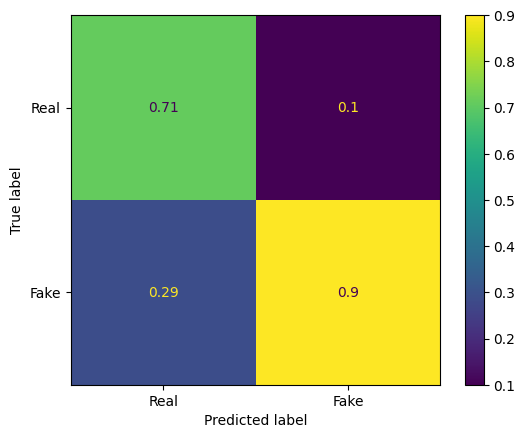

In [4]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score


def evaluate(valloader):
    true = []
    predictions = []
    with torch.no_grad():
        model.eval()
        for data in valloader:
            if next(model.parameters()).is_cuda:
                data = [t.to(device) for t in data if t is not None]

            tokens_tensors, segments_tensors, masks_tensors = data[:3]
            val_outputs = model(input_ids=tokens_tensors,
                                token_type_ids=segments_tensors,
                                attention_mask=masks_tensors)

            logits = val_outputs.logits
            _, pred = torch.max(logits, 1)

            labels = data[3]
            true.extend(labels.cpu().tolist())
            predictions.extend(pred.cpu().tolist())

    cm = confusion_matrix(true, predictions, labels=[1, 0], normalize='pred')
    print(cm)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Real', 'Fake'])
    disp.plot()

    accuracy = accuracy_score(true, predictions)
    precision = precision_score(true, predictions)
    recall = recall_score(true, predictions)
    f1 = f1_score(true, predictions)

    print('\nAccuracy:', accuracy)
    print('Precision:', precision)
    print('Recall:', recall)
    print('F1 Score:', f1)

    return accuracy, precision, recall, f1


# Example usage:
valset_electra = FakeNewsDatasetLIAR('val', tokenizer=tokenizer, path='./')
print('Electra valset size:', valset_electra.__len__())
valloader_electra = DataLoader(valset_electra, batch_size=BATCH_SIZE, collate_fn=create_mini_batch)

print('Electra:')
print('Confusion Matrix:')
evaluate(valloader_electra)
